# CTA Analysis - Visualizations
---
## Outline
This is part two of a two part analysis of the CTA Ridership data. In this section, I will focus on developing insights from the data. Since the data set is relatively small, and only contians data for October 2012, the analysis I will be doing is mostly categorical. Categorical is a powerful way to summarize the data.  

I'm going to use a mix of visualization tools my analysis. 
* Folium - a library to help visualize geospatial data (latitude and longitude)
* Matplotlib -  library used for plotting the beautiful and attractive graphs
* Seaborn - library to make graphs pretty

**Database model:**
![title](database/cta_bus_ridership_database_model.png)

## Set up environment

In [1]:
import os
import time
import sqlite3
import pandas as pd
import numpy as np
from selenium import webdriver

# import visualizations libraries
import folium
import matplotlib.pyplot as plt
import seaborn as sns
from folium import plugins
%matplotlib inline

In [2]:
# helper functions for sqlite3 
def connect(sqlite_file):
    """
    Make connection to an SQLite database file.
    """
    conn = sqlite3.connect(sqlite_file)
    c = conn.cursor()
    return conn, c

def close(conn):
    """ 
    Commit changes and close connection to the database.
    """
    conn.close()
    
def table_col_info(cursor, table_name, print_out=False):
    """
    Returns a list of tuples with column informations:
    (id, name, type, notnull, default_value, primary_key)
    """
    cursor.execute('PRAGMA TABLE_INFO({})'.format(table_name))
    info = cursor.fetchall()

    if print_out:
        print("\nColumn Info:\nID, Name, Type, NotNull, DefaultVal, PrimaryKey")
        for col in info:
            print(col)
    return info

# helper function for folium  
def folium_to_png(html_path, destination):
    """
    Quick and dirty function to convert folium html map to png file
    """
    browser = webdriver.Firefox()
    browser.get('file:///{}/{}'.format(os.getcwd(), html_path))
    time.sleep(5)  #Give the map some time to load
    browser.save_screenshot(destination)
    browser.quit()
    

In [3]:
# sql_db is my connection and sql_command is my cursor
sql_db, sql_command = connect('database/cta_bus_ridership.db')


## High level statistics of ridership data

In [4]:
# join latitude, longitude columns to bus_ridership table on stop_id
bus_ridership_coords = """
                        SELECT br.stop_id,
                               br.boardings,
                               br.alightings,
                               bs.latitude,
                               bs.longitude
                        FROM bus_ridership as br
                        JOIN bus_stops as bs on br.stop_id = bs.stop_id;
                       """
# load sql table into pandas dataframe
bus_ridership_coords_df = pd.read_sql_query(bus_ridership_coords, sql_db)


In [5]:
# get statistics on number columns only
bus_ridership_df = bus_ridership_coords_df[['stop_id', 'boardings', 'alightings']]
bus_ridership_df.describe()


,stop_id,boardings,alightings
count,11591.000000,11591.000000,11591.000000
mean,8137.074799,90.968294,90.954439
std,4931.645728,181.174714,175.264077
min,1.000000,0.000000,0.000000
25%,3835.500000,10.500000,12.550000
50%,8082.000000,33.600000,38.200000
75%,11838.500000,92.100000,97.100000
max,17710.000000,3366.300000,3418.300000


A few statistics give me perspective on the nature of the distribution of the data. For example, mean is the average and is the "expected" value of the distribution, which is around 90.95 for both `boardings` and `alightings`. I'm curious to discover the stops that have the most boardings and alightings.

The statistics also brings up an important point- how can you have boardings and alightings as floats? Surely, you can't have a rider count as 0.5 because that doesn't make any sense. We'll this is because the data is from an aggreagated monthy report of weekday ridership data. Which means the boarding and alightings fields are probably an average for the month.  


## Visualize all of the bus routes

In [6]:
# create to (n, 2) nd-array format for plotting and heatmap
stop_array = bus_ridership_coords_df[['latitude', 'longitude']].values

# create folium map of chicago
chicago_map = folium.Map([41.8781, -87.6298], zoom_start=10.9)

# mark each stop as a point on map
for latitude, longitude in stop_array:
    folium.CircleMarker([latitude, longitude],
                        radius = 0.5,
                        color="#3db7e4", 
                       ).add_to(chicago_map)

# plot heatmap
chicago_map.add_child(plugins.HeatMap(stop_array, radius=15, min_opacity=0.7))

# save heatmap
chicago_map.save('visualizations/bus_stops_heatmap.html')

# convert html to png
folium_to_png('visualizations/bus_stops_heatmap.html', 'visualizations/bus_stops_heatmap.png')


![title](visualizations/bus_stops_heatmap.png)

## What stops have the most routes? 

In [7]:
# join bus_stops to bus_routes on stop_id and
# count the number of routes each stop has, then order by the top routes
stop_most_routes = """
                    SELECT br.stop_id,
                           bs.on_street,
                           bs.cross_street,
                           COUNT(*) AS number_routes 
                    FROM bus_stops as bs
                    JOIN bus_routes as br ON bs.stop_id = br.stop_id
                    GROUP BY br.stop_id 
                    ORDER BY number_routes DESC LIMIT 10;
                   """
# load sql query into dataframe
stop_most_routes_df = pd.read_sql_query(stop_most_routes, sql_db)
stop_most_routes_df


,stop_id,on_street,cross_street,number_routes
0,1106,MICHIGAN,WASHINGTON,14
1,73,MICHIGAN,betw. VAN BUREN & CONGRES,13
2,1103,MICHIGAN,HUBBARD (WRIGLEY BLDG.),13
3,1120,MICHIGAN,SOUTH WATER,13
4,1122,MICHIGAN,HUBBARD (TRIBUNE BLDG.),13
5,1100,MICHIGAN,ERIE,12
6,1101,MICHIGAN,OHIO,12
7,1102,MICHIGAN,ILLINOIS,12
8,1105,MICHIGAN,betw. LAKE & RANDOLPH,12
9,1123,MICHIGAN,GRAND,12


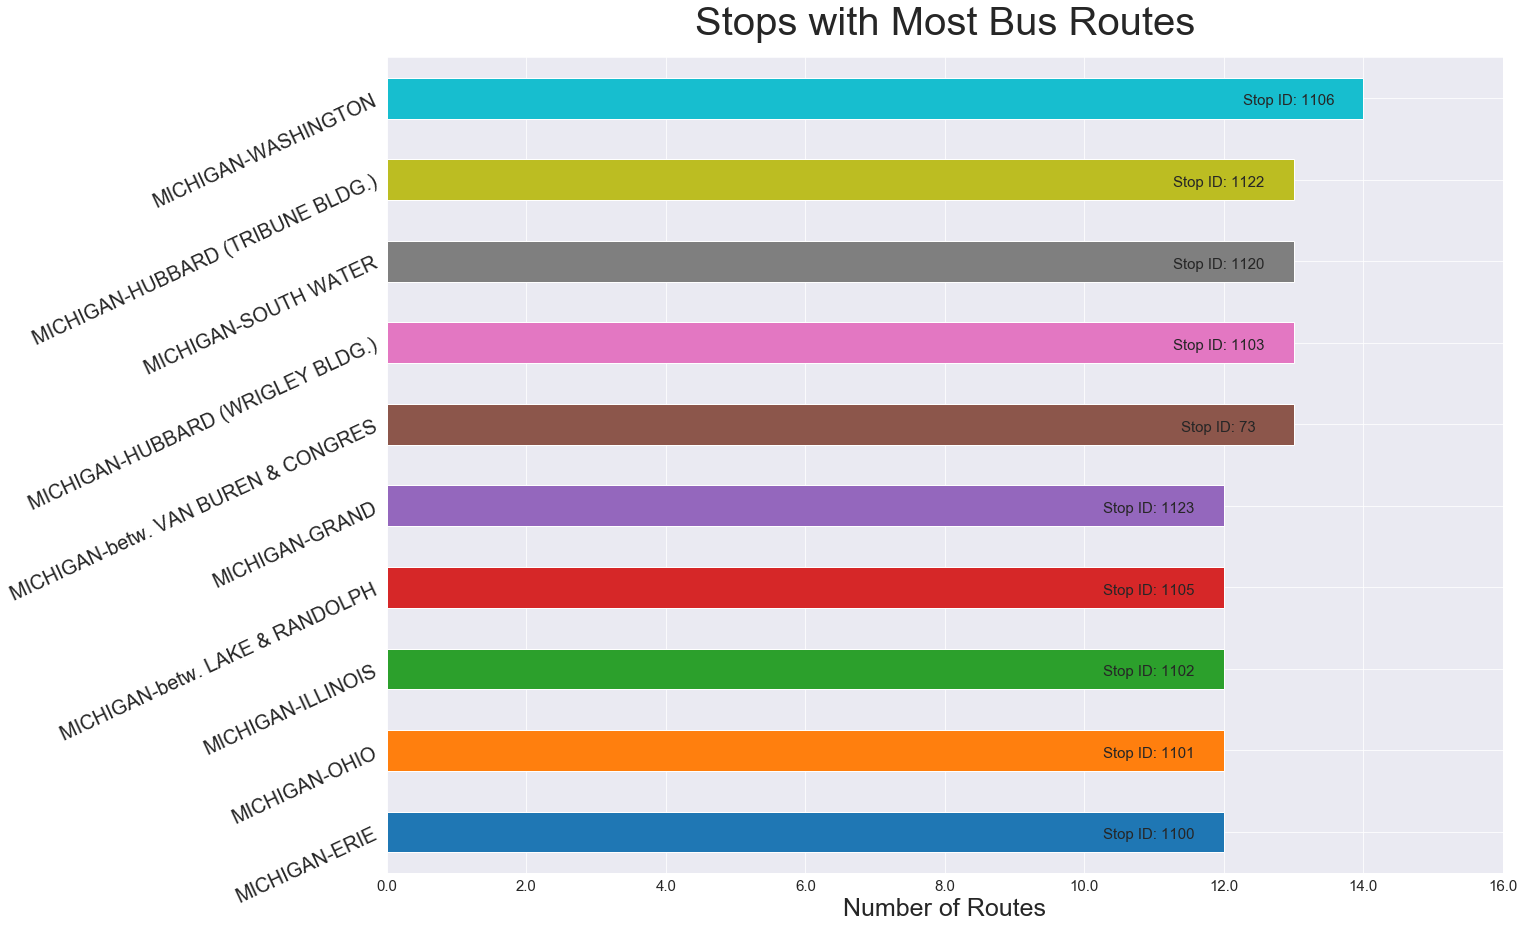

In [8]:
# prepare data for plotting
stop_most_routes_df['stop_address'] = stop_most_routes_df['on_street'] + '-' + stop_most_routes_df['cross_street']
stop_most_routes_values = stop_most_routes_df[['stop_id', 'stop_address', 'number_routes']]
stop_most_routes_values = stop_most_routes_values.sort_values('number_routes', ascending=True)

# make plot
sns.set_style("darkgrid")
ax = stop_most_routes_values.plot(kind='barh', x='stop_address', y='number_routes', figsize=(20,15))
ax.set_title('Stops with Most Bus Routes', size=40, y=1.02)
ax.set_xlabel('Number of Routes', size=25)
xticks = ax.get_xticks()
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, size=15)
ax.set_ylabel('')
ax.set_yticklabels(stop_most_routes_values.stop_address, size=20, rotation=25)
ax.get_legend().remove()

rects = ax.patches
labels = ['Stop ID: {}'.format(stop_id) for stop_id in stop_most_routes_values.stop_id.tolist()]

for rect, label in zip(rects, labels):
    
    # Get X and Y placement of label from rect.
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    
    # Use X value as label and format number with one decimal place
    label = label
    
    # Create annotation
    plt.annotate(
        label,                       # Use `label` as label
        (x_value, y_value),          # Place label at end of the bar
        xytext=(-75, 4),             # Horizontally shift label by `space`
        textcoords="offset points",  # Interpret `xytext` as offset in points
        ha='center',                 # Vertically center label
        va = 'top',                  # Horizontally align label
        size = 15)                 

# save chart
plt.savefig('visualizations/stops_with_most_bus_routes.png')


## What bus routes have the most stops?

In [9]:
# join bus_routes to bus_stops on stop_id and
# count the number of stops each route has, then order by the top stops
route_most_stops = """
                    SELECT br.route,
                           bs.on_street,
                           COUNT(*) AS total_stops
                    FROM bus_routes as br 
                    JOIN bus_stops as bs ON br.stop_id = bs.stop_id
                    GROUP BY br.route 
                    ORDER BY total_stops DESC LIMIT 10;
                   """
# read sql query into dataframe
route_most_stops_df = pd.read_sql_query(route_most_stops, sql_db)
route_most_stops_df


,route,on_street,total_stops
0,9,ASHLAND,273
1,49,WESTERN,242
2,151,ADAMS,221
3,8,HALSTED,220
4,3,MICHIGAN,213
5,82,HOMAN,209
6,62,STATE,206
7,79,79TH STREET,206
8,N5,S. SHORE DRIVE,206
9,4,COTTAGE GROVE,202


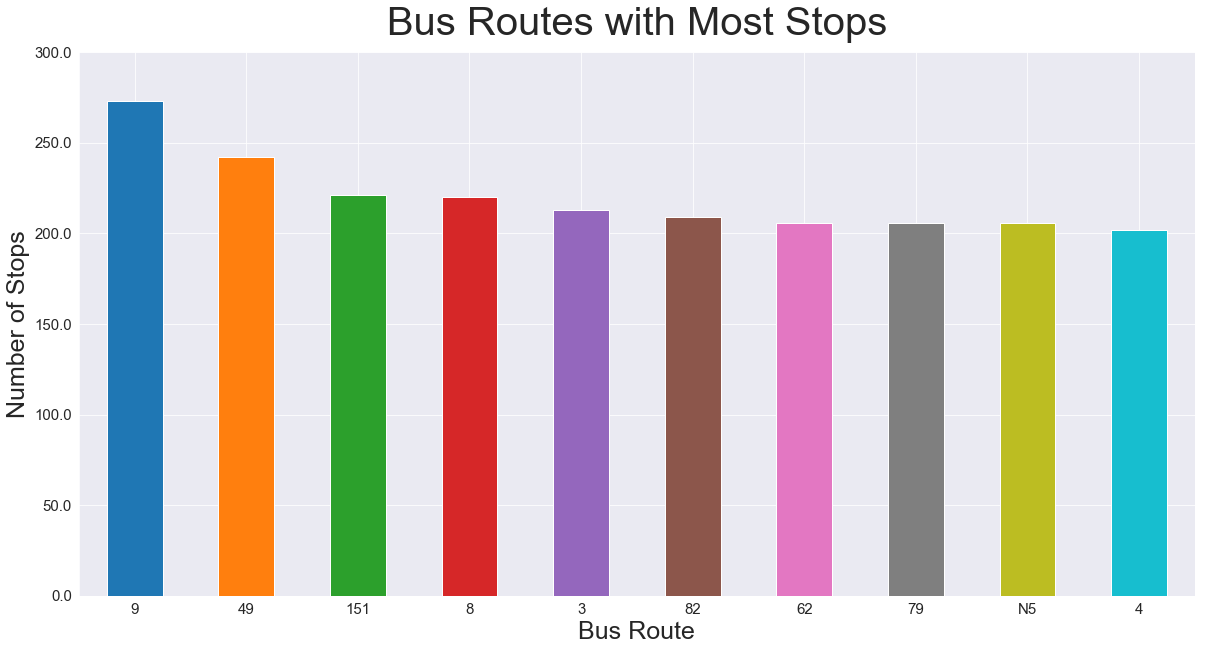

In [10]:
# make plot
sns.set_style("darkgrid")
ax = route_most_stops_df.plot(kind='bar', x='route', y='total_stops', figsize=(20,10))
ax.set_title('Bus Routes with Most Stops', size=40, y=1.02)
ax.set_xlabel('Bus Route', size=25)
ax.set_xticklabels(route_most_stops_df.route, size=15, rotation=360)
ax.set_ylabel('Number of Stops', size=25)
yticks = ax.get_yticks()
ax.set_yticks(yticks)
ax.set_yticklabels(yticks, size=15)
ax.get_legend().remove()

# save chart
plt.savefig('visualizations/bus_routes_with_most_stops.png')


## Visualize bus routes with the most stops

In [11]:
# join bus_stops to bus_routes on stop_id with coordinates
route_most_stops_coords = """
                            SELECT bs.stop_id,
                                   br.route,
                                   bs.latitude,
                                   bs.longitude
                            FROM bus_stops as bs
                            JOIN bus_routes as br on br.stop_id = bs.stop_id;
                          """
# join the route and coordinates data to previous dataframe with 
# bus routes that have the most stops 
route_most_stops_coords_df = pd.read_sql_query(route_most_stops_coords, sql_db)
route_most_stops_coords_df = pd.merge(route_most_stops_df, 
                                      route_most_stops_coords_df, 
                                      on='route')


In [12]:
# create to (n, 2) nd-array format for plotting
route_most_stop_array = route_most_stops_coords_df[['latitude', 'longitude']].values

# create folium map of chicago
route_most_stops_map = folium.Map([41.8781, -87.6298], zoom_start=11.4)

# mark each stop as a point on map
for latitude, longitude in route_most_stop_array:
    folium.CircleMarker([latitude, longitude],
                        radius = 2,
                        color="#3db7e4", 
                       ).add_to(route_most_stops_map)

# save heatmap
route_most_stops_map.save('visualizations/bus_route_most_stops_map.html')

folium_to_png('visualizations/bus_route_most_stops_map.html', 'visualizations/bus_route_most_stops_map.png')


## Visualize bus routes with most stops

![title](visualizations/bus_route_most_stops_map.png)

The Chicago grid system is amazing and I'm sure plays an important part in CTA logitics. As you can see, most of the busiest bus routes run vertical in Chicago. The Ashland Bus #9 is the route with the most stops at 273!

## Top bus stop boardings

In [13]:
top_stop_boardings = """
                        SELECT bs.stop_id,
                               bs.on_street,
                               bs.cross_street,
                               br.boardings,
                               br.alightings
                        FROM bus_stops as bs
                        JOIN bus_ridership as br ON bs.stop_id = br.stop_id
                        ORDER BY boardings DESC LIMIT 10;
                     """

top_stop_boardings_df = pd.read_sql_query(top_stop_boardings, sql_db)
top_stop_boardings_df


,stop_id,on_street,cross_street,boardings,alightings
0,14011,95TH STREET,RED LINE STATION,3366.3,3418.3
1,16140,ROOSEVELT,GREEN/ORANGE/RED LINE,3192.1,1777.5
2,17097,79TH STREET,RED LINE STATION,2691.3,2362.7
3,1127,MICHIGAN,CHESTNUT,2595.3,1434.3
4,1106,MICHIGAN,WASHINGTON,2559.3,2232.8
5,4729,MADISON,STATE,2550.2,1136.4
6,17380,BELMONT,SHEFFIELD,2490.0,938.2
7,5009,CANAL,ADAMS,2433.6,1613.1
8,1225,FULLERTON,RED/BROWN/PURPLE LINE STA,2356.3,112.6
9,1425,STATE,WASHINGTON,2163.0,1046.7


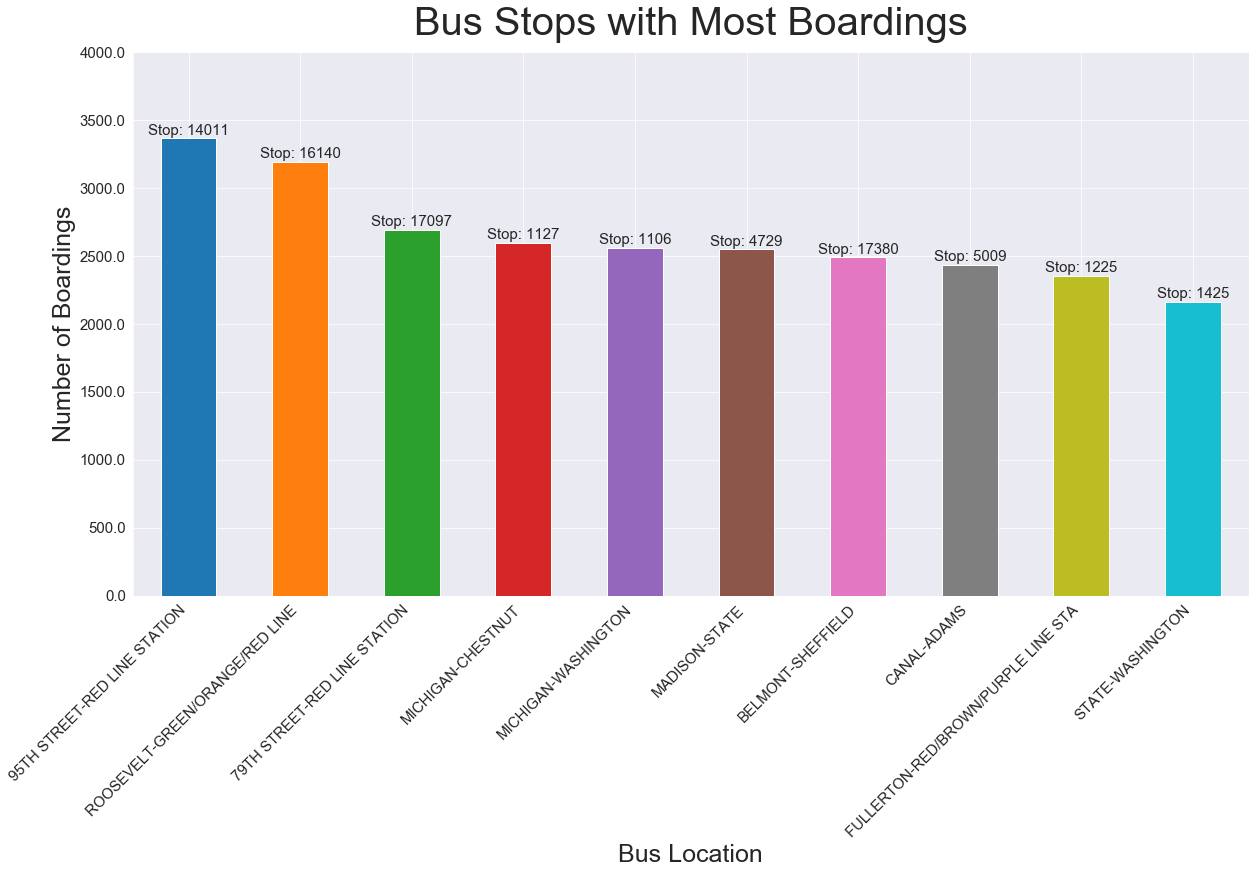

In [14]:
# prepare data for plotting
top_stop_boardings_df['stop_address'] = top_stop_boardings_df['on_street'] + '-' + top_stop_boardings_df['cross_street']

# make plot
sns.set_style("darkgrid")
ax = top_stop_boardings_df.plot(kind='bar', x='stop_address', y='boardings', figsize=(20,10))
ax.set_title('Bus Stops with Most Boardings', size=40, y=1.02)
ax.set_xlabel('Bus Location', size=25)
ax.set_xticklabels(top_stop_boardings_df.stop_address, size=15, rotation=45, ha='right')
ax.set_ylabel('Number of Boardings', size=25)
yticks = ax.get_yticks()
ax.set_yticks(yticks)
ax.set_yticklabels(yticks, size=15)
ax.get_legend().remove()

rects = ax.patches
labels = ['Stop: {}'.format(stop_id) for stop_id in top_stop_boardings_df.stop_id.tolist()]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom', size=15)
    
# save chart
plt.savefig('visualizations/bus_stops_most_boardings.png')


I'm not surprise to see that the most bus boardings happen at CTA train stops. What is interesting, is the Red line has most people boarding buses. Especially on the southside of the city.

## Top bus stop alightings (exits)

In [15]:
top_stop_alightings = """
                        SELECT bs.stop_id,
                               bs.on_street,
                               bs.cross_street,
                               br.boardings,
                               br.alightings
                        FROM bus_stops as bs
                        JOIN bus_ridership as br ON bs.stop_id = br.stop_id
                        ORDER BY alightings DESC LIMIT 10;
                     """

top_stop_alightings_df = pd.read_sql_query(top_stop_alightings, sql_db)
top_stop_alightings_df


,stop_id,on_street,cross_street,boardings,alightings
0,14011,95TH STREET,RED LINE STATION,3366.3,3418.3
1,17037,JEFFERSON PARK,BLUE LINE STATION/NORTH B,115.8,2580.2
2,17379,BELMONT,SHEFFIELD,715.9,2575.0
3,17038,JEFFERSON PARK,BLUE LINE STATION/SOUTH B,91.3,2546.3
4,17538,KEDZIE,ORANGE LINE STATION,233.8,2542.8
5,12713,ADAMS,CANAL,326.3,2513.8
6,14012,95TH STREET,RED LINE STATION,59.2,2458.5
7,1105,MICHIGAN,betw. LAKE & RANDOLPH,1526.6,2405.5
8,316,ROOSEVELT,STATE,322.2,2370.9
9,17097,79TH STREET,RED LINE STATION,2691.3,2362.7


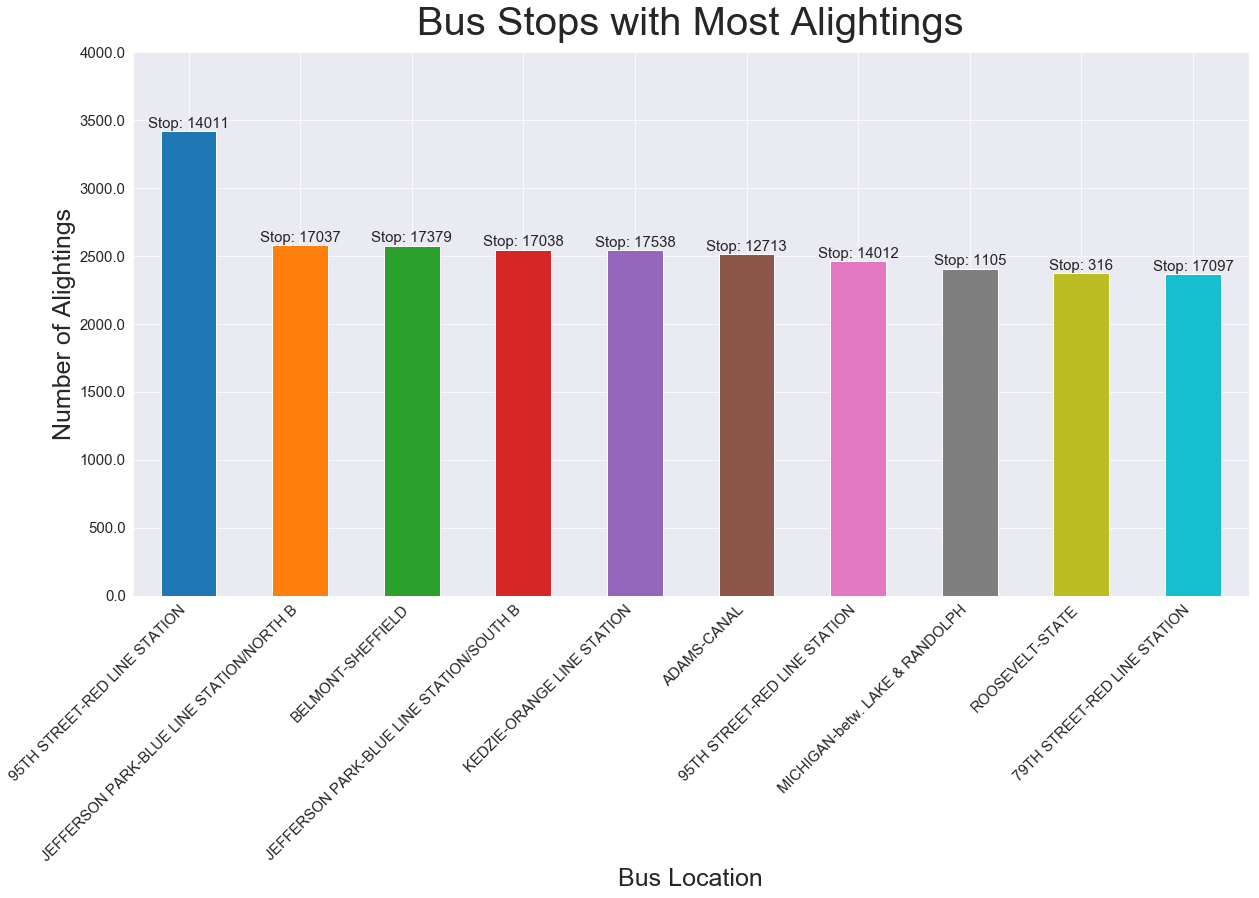

In [16]:
# prepare data for plotting
top_stop_alightings_df['stop_address'] = top_stop_alightings_df['on_street'] + '-' + top_stop_alightings_df['cross_street']

# make plot
sns.set_style("darkgrid")
ax = top_stop_alightings_df.plot(kind='bar', x='stop_address', y='alightings', figsize=(20,10))
ax.set_title('Bus Stops with Most Alightings', size=40, y=1.02)
ax.set_xlabel('Bus Location', size=25)
ax.set_xticklabels(top_stop_alightings_df.stop_address, size=15, rotation=45, ha='right')
ax.set_ylabel('Number of Alightings', size=25)
yticks = ax.get_yticks()
ax.set_yticks(yticks)
ax.set_yticklabels(yticks, size=15)
ax.get_legend().remove()

rects = ax.patches
labels = ['Stop: {}'.format(stop_id) for stop_id in top_stop_alightings_df.stop_id.tolist()]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom', size=15)
    
# save chart
plt.savefig('visualizations/bus_stop_with_most_alightings.png')


Again, the CTA Red Line stop make the charts with the most Bus alightings (exits)! Even though the data is from October 2012, these reports are significant and relevant today. In 2018, the CTA announced an extension project on the Ride Line. The project is proposing to extend the Red Line from 95th Street to 130th Street with multiple stops inbetween. I'm sure the number of bus passengers have only increase over the years and the extension would help to improve the mobility and accessibility for the transit-dependent residents in the area. Meaning residents could be less dependented on a bus route and instead take the train.  

You can read more about the redline extension project here: https://www.transitchicago.com/redext/

In [17]:
# close database connection
close(sql_db)


## Thank you! 
I hope you enjoyed my analysis of the the CTA Ridership Data. I'm looking forward to explaining my results and going over the data. I'm looking forward to meeting everyone at Cameo on Wednesday, January 2nd. 

Happy New Year!